# Compare basic and meta teacher

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.distributions as torch_dist
from tensordict import TensorDict

from lift.environments.gym_envs import NpGymEnv
from lift.environments.teacher_envs import TeacherEnv, ConditionedTeacher
from lift.environments.rollout import rollout
from lift.rl.sac_meta import MetaSAC

from lift.teacher import load_teacher
from configs import BaseConfig

In [2]:
# make figure path
fig_path = "../figs"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

In [3]:
config = BaseConfig()

meta_teacher = load_teacher(config, meta=True)
conditioned_teacher = ConditionedTeacher(
    meta_teacher,
    alpha_apply_range=[0., 3.])
conditioned_teacher.reset()

basic_teacher = load_teacher(config, meta=False)


MetaSAC teacher loaded

SAC teacher loaded


In [4]:
def eval_teacher_rollout(
    teacher, 
    env_noise, 
    env_noise_slope, 
    teacher_noise, 
    teacher_noise_slope, 
    n_steps=3000,
):
    env = NpGymEnv("FetchReachDense-v2", max_episode_steps=100)
    env = TeacherEnv(
        env, 
        noise_range=[env_noise, env_noise], 
        noise_slope_range=[env_noise_slope, env_noise_slope], 
        append_obs=False,
    )

    data = rollout(
        env,
        teacher,
        n_steps=n_steps,
        terminate_on_done=False,
        reset_on_done=True,
        random_pertube_prob=0.,
        action_noise=0.,
    )

    data['env_noise'] = env_noise
    data['env_noise_slope'] = env_noise_slope

    return data

In [5]:
def compute_mae_std(data):
    with torch.no_grad():
        dist = conditioned_teacher.get_action_dist(data['obs'])
        meta_actions = dist.sample()
    abs_err = np.abs(data['act'] - meta_actions.numpy())
    return abs_err.mean(), dist.scale.mean().item()

def compute_kl(data):
    o = torch.tensor(data['obs']['observation'], dtype=torch.float32)
    z = torch.tensor(data['act'], dtype=torch.float32)

    basic_inputs = TensorDict({
        "observation": o,
        "action": z,
    })

    # with torch.no_grad():
    #     log_prior = conditioned_teacher.get_action_dist(data['obs']).log_prob(z)
    #     z_dist = basic_teacher.model.policy.get_dist(basic_inputs)
    # ent = -z_dist.log_prob(z)
    # kl = -(log_prior + ent).mean()

    # closed form kl
    with torch.no_grad():
        dist1 = conditioned_teacher.get_action_dist(data['obs'])
        dist2 = basic_teacher.model.policy.get_dist(basic_inputs)
        kl = torch_dist.kl.kl_divergence(
            torch_dist.Normal(dist1.mode, dist1.scale),
            torch_dist.Normal(dist2.mode, dist2.scale),
        ).sum(-1).mean()
    return kl

In [10]:
np.random.seed(0)

def evaluate_rollout(eval_rollout, alpha, teacher_noises, teacher_noise_slopes):
    num_rows = len(teacher_noises)
    num_cols = len(teacher_noise_slopes)

    results = {
        'kl' : np.zeros((num_rows, num_cols)),
        'mae': np.zeros((num_rows, num_cols)),
        'scale': np.zeros((num_rows, num_cols)),
    }

    for i, teacher_noise in enumerate(teacher_noises):
        for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
            # update conditioned teacher
            meta_vars = {
                'noise': teacher_noise,
                'noise_slope': teacher_noise_slope,
                'alpha': alpha,
            }
            conditioned_teacher.set_meta_vars(meta_vars)

            eval_rollout['teacher_noise'] = torch.tensor(teacher_noise)
            eval_rollout['teacher_noise_slope'] = torch.tensor(teacher_noise_slope)
            results['mae'][i,j], results['scale'][i,j] = compute_mae_std(eval_rollout)
            results['kl'][i,j] = compute_kl(eval_rollout)

    return results, teacher_noises, teacher_noise_slopes

In [8]:
# eval teacher with different meta variables in the same environment
env_noise = 0.
env_noise_slope = 0.

teacher_noise = None
teacher_noise_slope = None

eval_rollout_1 = eval_teacher_rollout(
    basic_teacher,
    env_noise, 
    env_noise_slope,
    teacher_noise,
    teacher_noise_slope,
)

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 951.07item/s] 


In [9]:
env_noise = 1.
env_noise_slope = 1.

teacher_noise = None
teacher_noise_slope = None

eval_rollout_2 = eval_teacher_rollout(
    basic_teacher,
    env_noise, 
    env_noise_slope,
    teacher_noise,
    teacher_noise_slope,
)

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 977.25item/s] 


In [12]:
torch.manual_seed(0)
num_rows = 6
num_cols = 6
teacher_noises = np.linspace(0.001, 0.9, num=num_rows)
teacher_noise_slopes = np.linspace(0.001, 0.9, num=num_cols)

alpha = 1
results_1, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_1, alpha, teacher_noises, teacher_noise_slopes)
results_2, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_2, alpha, teacher_noises, teacher_noise_slopes)

alpha = 3
results_3, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_1, alpha, teacher_noises, teacher_noise_slopes)
results_4, teacher_noises, teacher_noise_slopes = evaluate_rollout(eval_rollout_2, alpha, teacher_noises, teacher_noise_slopes)

In [13]:
def plot_heat_map(eval_stats, ax, xlabel, ylabel, cmap="Blues", vmin=None, vmax=None):
    df = pd.DataFrame(
        eval_stats, 
        index=[round(i, 2) for i in teacher_noises.tolist()], 
        columns=[round(i, 2) for i in teacher_noise_slopes.tolist()], 
    )
    sns.heatmap(df, annot=True, cbar=False, fmt=".2f", cmap=cmap, ax=ax, vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

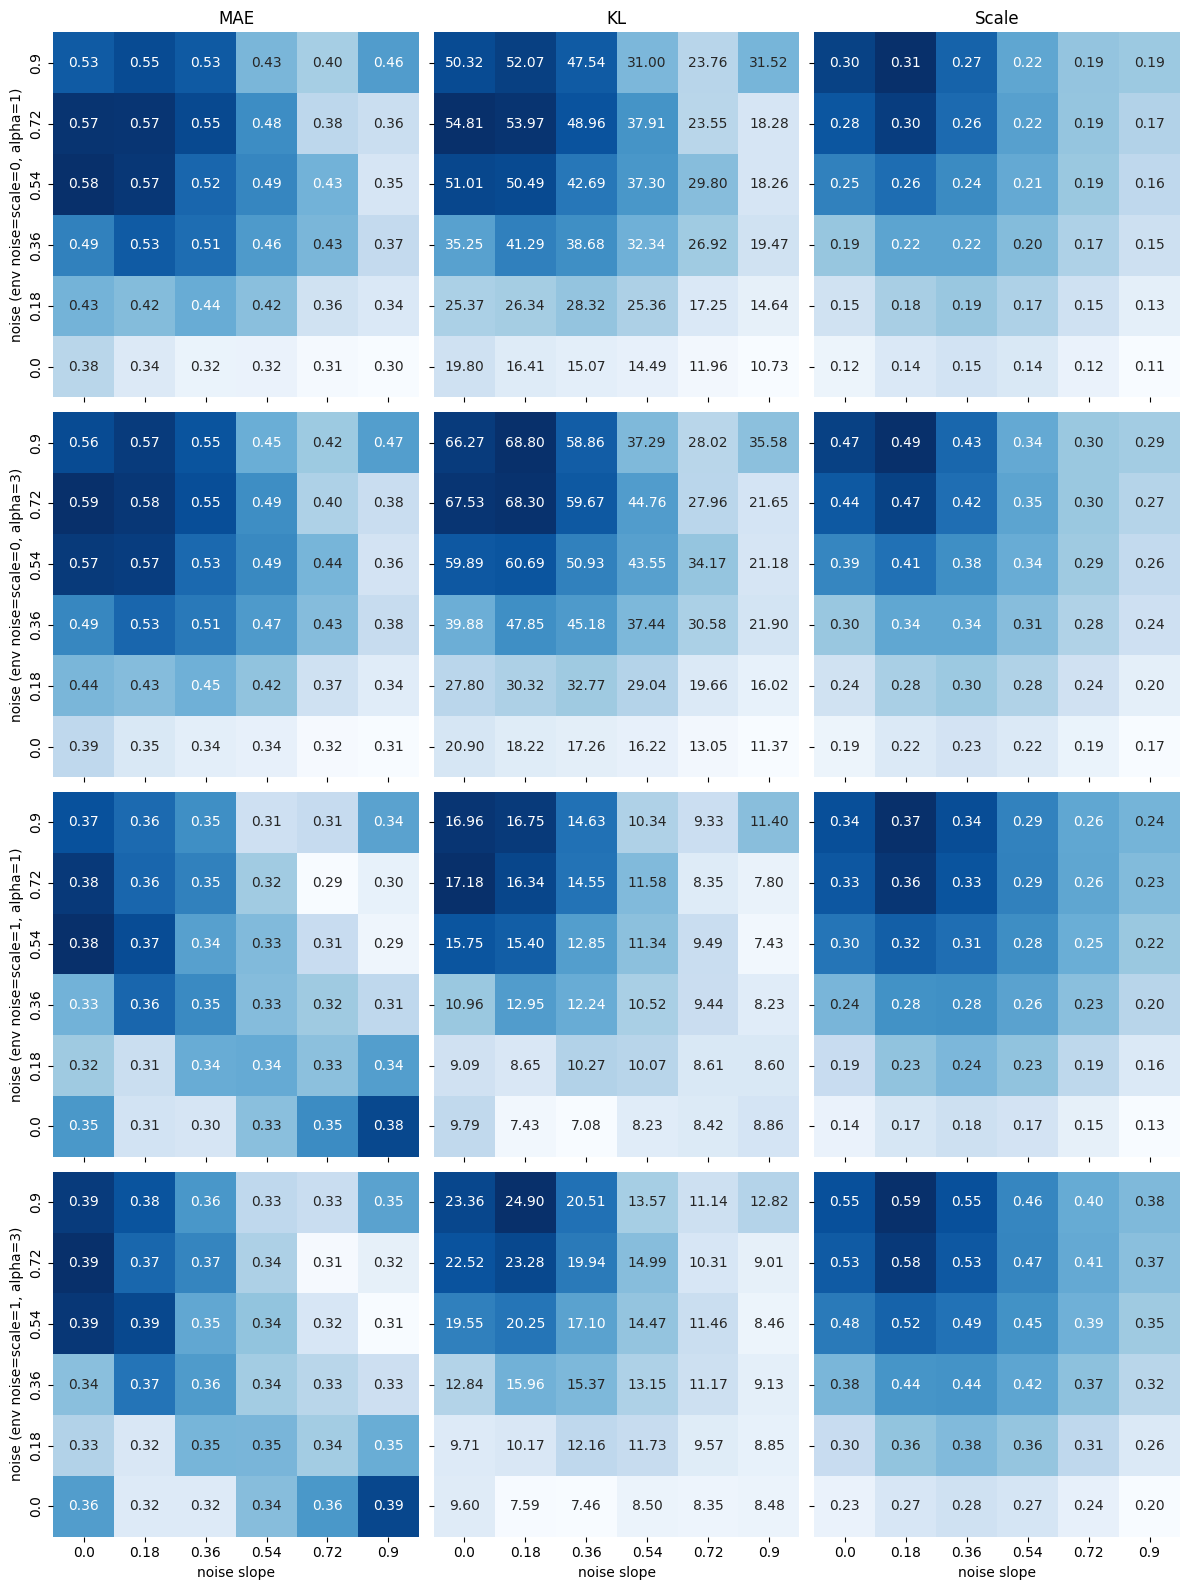

In [14]:
fig, ax = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)
plot_heat_map(results_1['mae'], ax[0,0], "", "noise (env noise=scale=0, alpha=1)")
plot_heat_map(results_1['kl'], ax[0,1], "", "")
plot_heat_map(results_1['scale'], ax[0,2], "", "")
plot_heat_map(results_2['mae'], ax[2,0], "", "noise (env noise=scale=1, alpha=1)")
plot_heat_map(results_2['kl'], ax[2,1], "", "")
plot_heat_map(results_2['scale'], ax[2,2], "", "")
plot_heat_map(results_3['mae'], ax[1,0], "", "noise (env noise=scale=0, alpha=3)")
plot_heat_map(results_3['kl'], ax[1,1], "", "")
plot_heat_map(results_3['scale'], ax[1,2], "", "")
plot_heat_map(results_4['mae'], ax[3,0], "noise slope", "noise (env noise=scale=1, alpha=3)")
plot_heat_map(results_4['kl'], ax[3,1], "noise slope", "")
plot_heat_map(results_4['scale'], ax[3,2], "noise slope", "")

ax[0,0].set_title("MAE")
ax[0,1].set_title("KL")
ax[0,2].set_title("Scale")
plt.tight_layout()

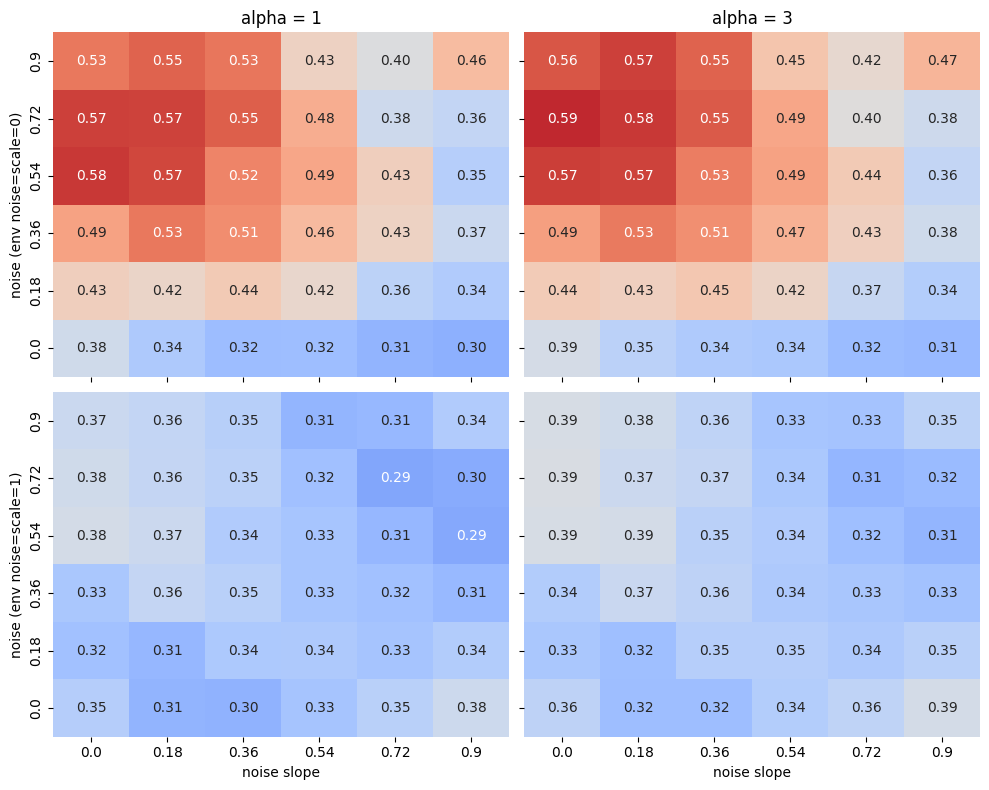

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

cmap = sns.color_palette("coolwarm", as_cmap=True)

plot_heat_map(results_1['mae'], ax[0,0], "", "noise (env noise=scale=0)", cmap=cmap, vmin=0.2, vmax=0.6)
plot_heat_map(results_2['mae'], ax[1,0], "noise slope", "noise (env noise=scale=1)", cmap=cmap, vmin=0.2, vmax=0.6)
plot_heat_map(results_3['mae'], ax[0,1], "", "", cmap=cmap, vmin=0.2, vmax=0.6)
plot_heat_map(results_4['mae'], ax[1,1], "noise slope", "", cmap=cmap, vmin=0.2, vmax=0.6)

ax[0,0].set_title("alpha = 1")
ax[0,1].set_title("alpha = 3")
plt.tight_layout()

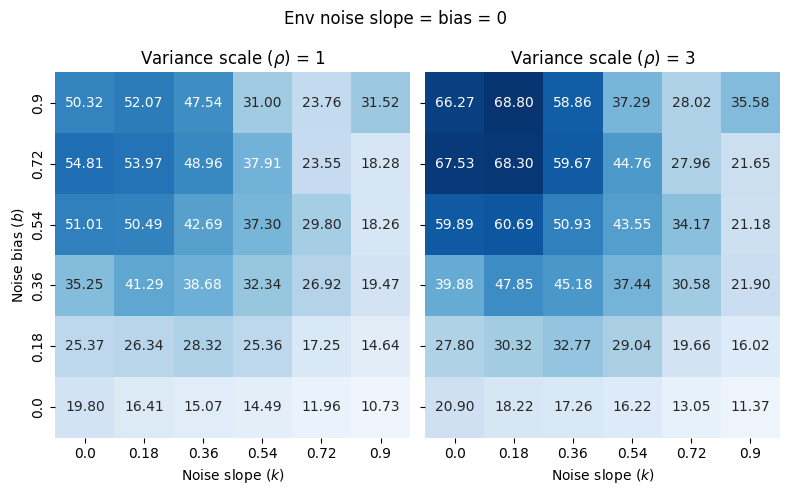

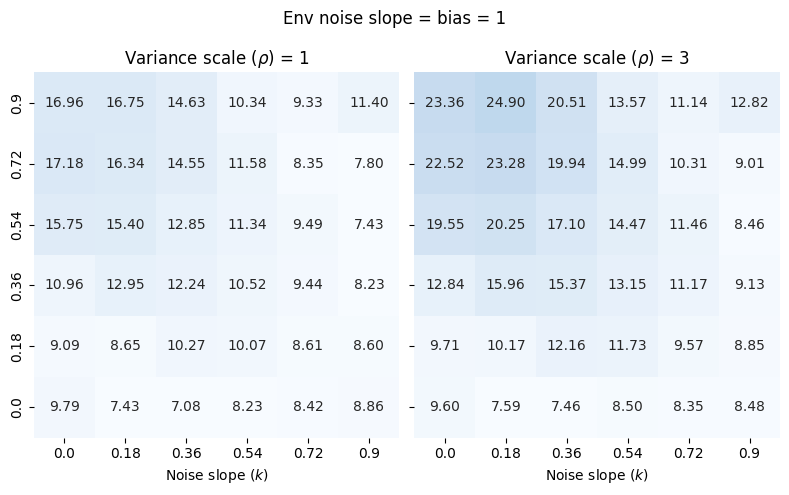

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

vmin = 8
vmax = 70
cmap = sns.color_palette("Blues", as_cmap=True)

plot_heat_map(results_1['kl'], ax[0], r"Noise slope ($k$)", r"Noise bias ($b$)", cmap=cmap, vmin=vmin, vmax=vmax)
plot_heat_map(results_3['kl'], ax[1], r"Noise slope ($k$)", "", cmap=cmap, vmin=vmin, vmax=vmax)

ax[0].set_title(r"Variance scale ($\rho$) = 1")
ax[1].set_title(r"Variance scale ($\rho$) = 3")
plt.suptitle("Env noise slope = bias = 0")
plt.tight_layout()

fig.savefig(os.path.join(fig_path, "kl_no_noise.png"), dpi=200)

print()

fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

plot_heat_map(results_2['kl'], ax[0], r"Noise slope ($k$)", "", cmap=cmap, vmin=vmin, vmax=vmax)
plot_heat_map(results_4['kl'], ax[1], r"Noise slope ($k$)", "", cmap=cmap, vmin=vmin, vmax=vmax)

ax[0].set_title(r"Variance scale ($\rho$) = 1")
ax[1].set_title(r"Variance scale ($\rho$) = 3")
plt.suptitle("Env noise slope = bias = 1")
plt.tight_layout()

fig.savefig(os.path.join(fig_path, "kl_is_noise.png"), dpi=200)

# Policies
how do different meta parameters differ in the policy, such as rewards and action std

In [18]:
def eval_teacher_rollout(
    teacher, 
    env_noise, 
    env_noise_slope, 
    teacher_noise, 
    teacher_noise_slope, 
    alpha,
    n_steps=3000,
):
    env = NpGymEnv("FetchReachDense-v2", max_episode_steps=100)
    env = TeacherEnv(
        env, 
        noise_range=[env_noise, env_noise], 
        noise_slope_range=[env_noise_slope, env_noise_slope], 
        append_obs=False,
    )

    if isinstance(teacher, MetaSAC):
        conditioned_teacher = ConditionedTeacher(
            teacher, 
            noise_range=[teacher_noise, teacher_noise], 
            noise_slope_range=[teacher_noise_slope, teacher_noise_slope], 
            alpha_range=[alpha, alpha],
        )
        conditioned_teacher.reset()
        teacher = conditioned_teacher

    data = rollout(
        env,
        teacher,
        n_steps=n_steps,
        terminate_on_done=False,
        reset_on_done=True,
        random_pertube_prob=0.,
        action_noise=0.,
    )

    data['env_noise'] = env_noise
    data['env_noise_slope'] = env_noise_slope

    return data

In [19]:
def compute_stats(eval_data, func):
    num_rows = len(eval_data)
    num_cols = len(eval_data[0])
    return np.array([[func(eval_data[i][j]) for j in range(num_cols)] for i in range(num_rows)])

def compute_mean_reward(data):
    return data["rwd"].mean()

def compute_act_abs(data):
    return np.abs(data["act"]).mean()

In [20]:
env_noise = 0.
env_noise_slope = 0.
alpha = 1

num_rows = 6
num_cols = 6
teacher_noises = torch.linspace(0.001, 0.9, steps=num_rows)
teacher_noise_slopes = torch.linspace(0.001, 0.9, steps=num_cols)

eval_rollout_policy_1 = {
    'meta': [[None for _ in range(num_cols)] for _ in range(num_rows)]
}

for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
        eval_rollout_policy_1['meta'][i][j] = eval_teacher_rollout(
            meta_teacher,
            env_noise,
            env_noise_slope,
            teacher_noise,
            teacher_noise_slope,
            alpha,
        )

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 977.10item/s] 


In [21]:
env_noise = 1.
env_noise_slope = 1.
alpha = 1

num_rows = 6
num_cols = 6
teacher_noises = torch.linspace(0.001, 0.9, steps=num_rows)
teacher_noise_slopes = torch.linspace(0.001, 0.9, steps=num_cols)

eval_rollout_policy_2 = {
    'meta': [[None for _ in range(num_cols)] for _ in range(num_rows)]
}

for i, teacher_noise in enumerate(teacher_noises):
    for j, teacher_noise_slope in enumerate(teacher_noise_slopes):
        eval_rollout_policy_2['meta'][i][j] = eval_teacher_rollout(
            meta_teacher,
            env_noise,
            env_noise_slope,
            teacher_noise,
            teacher_noise_slope,
            alpha,
        )

Rollout: 100%|██████████| 3000/3000 [00:03<00:00, 977.90item/s] 


In [23]:
evals_rwd_mean_1 = {k: compute_stats(v, compute_mean_reward) for k, v in eval_rollout_policy_1.items()}
evals_act_abs_1 = {k: compute_stats(v, compute_act_abs) for k, v in eval_rollout_policy_1.items()}

evals_rwd_mean_2 = {k: compute_stats(v, compute_mean_reward) for k, v in eval_rollout_policy_2.items()}
evals_act_abs_2 = {k: compute_stats(v, compute_act_abs) for k, v in eval_rollout_policy_2.items()}

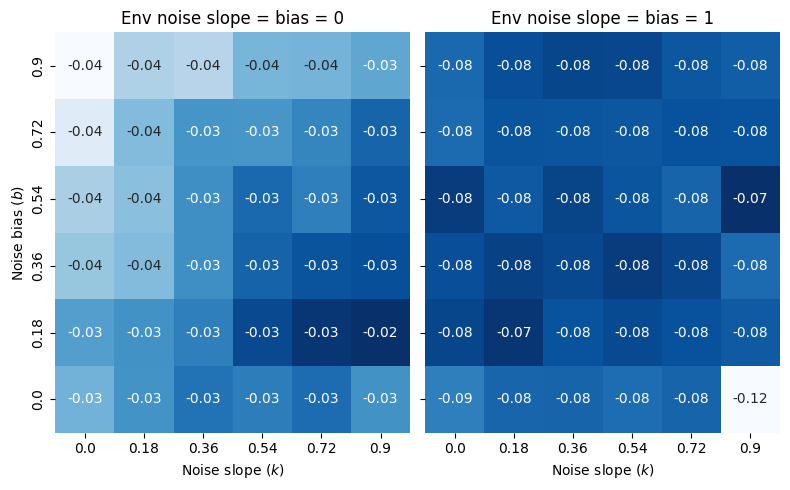

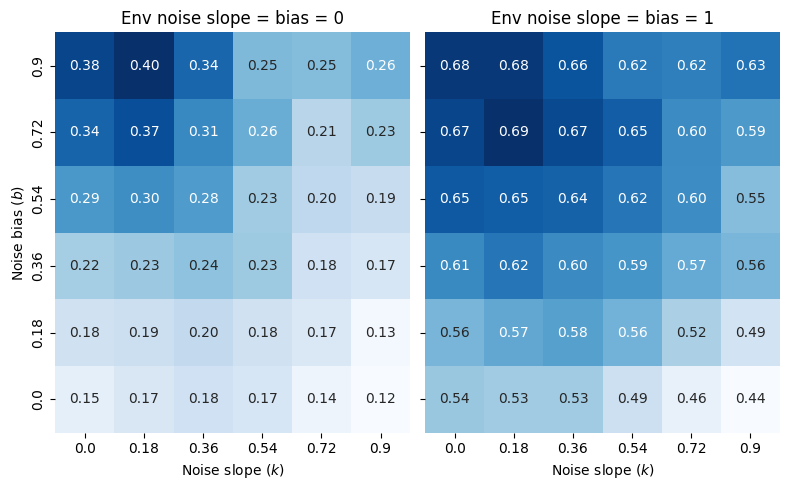

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)
cmap = sns.color_palette("Blues", as_cmap=True)
vmin = None
vmax = None
plot_heat_map(evals_rwd_mean_1['meta'], ax[0], r"Noise slope ($k$)", r"Noise bias ($b$)", cmap=cmap, vmin=vmin, vmax=vmax)
plot_heat_map(evals_rwd_mean_2['meta'], ax[1], r"Noise slope ($k$)", "", cmap=cmap, vmin=vmin, vmax=vmax)
ax[0].set_title("Env noise slope = bias = 0")
ax[1].set_title("Env noise slope = bias = 1")
plt.tight_layout()

fig.savefig(os.path.join(fig_path, "user_reward.png"), dpi=200)

print()

fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)
cmap = sns.color_palette("Blues", as_cmap=True)
vmin = None
vmax = None
plot_heat_map(evals_act_abs_1['meta'], ax[0], r"Noise slope ($k$)", r"Noise bias ($b$)", cmap=cmap, vmin=vmin, vmax=vmax)
plot_heat_map(evals_act_abs_2['meta'], ax[1], r"Noise slope ($k$)", "", cmap=cmap, vmin=vmin, vmax=vmax)
ax[0].set_title("Env noise slope = bias = 0")
ax[1].set_title("Env noise slope = bias = 1")
plt.tight_layout()

fig.savefig(os.path.join(fig_path, "user_act_abs.png"), dpi=200)